# Semidefinite Relaxation of AC Optimal Power Flow Problems

This notebook demonstrates the use of semidefinite relaxation techniques for AC optimal power flow (ACOPF) problems. A description of the problem formulation and its implementation can be found in the following paper:

> M. S. Andersen, A. Hansson, L. Vandenberghe, "[Reduced-Complexity Semidefinite Relaxations of Optimal Power Flow Problems](https://doi.org/10.1109/TPWRS.2013.2294479)", IEEE Transactions on Power Systems, 29 (4), pp. 1855–1863, 2014.

To run this notebook, you will need [CVXOPT](http://cvxopt.org), [CHOMPACK](https://cvxopt.github.io/chompack), [MOSEK](https://www.mosek.com), and [Matplotlib](http://matplotlib.org).

## Test cases

[MATPOWER](https://github.com/MATPOWER/matpower) provides a number of test cases that are basically MATLAB m-files. Most of which (those that do not perform any computations inside the m-files) can be loaded directly from a file or from a url. For example, the following code
```
from opfsdr import opf
prob = opf('https://github.com/MATPOWER/matpower/blob/master/data/case300.m')
```
downloads the `case300` test case from the MATPOWER repository on Github and generates a semidefinite relaxation problem. Alternatively, using the [Github API](https://developer.github.com/v3/), a list of test cases and their urls can be retrieved from the MATPOWER repository as follows:

In [1]:
import json, re
from urllib import urlopen
response = urlopen('https://api.github.com/repos/MATPOWER/matpower/contents/data')
clist = json.loads(response.read())
testcases = []
for c in clist:
    casename = c['name'].split('.')[0]
    testcases.append({'name':casename,
                      'url': c['download_url'],
                      'busses': int(re.search('case[a-z\_]*([0-9]+)',casename).group(1))})

## Building and solving ACOPFs

The following example illustrates how to use `opfsdr` to download a test case, form a semidefinite relaxation problem, and how solve this problem:

In [2]:
from opfsdr import opf

# select first test case with 1354 busses
case = [tc for tc in testcases if tc['busses'] == 1354][0]
print("Test case: %s" % case['name'])
options = {'conversion': True,          # apply chordal conversion? (default: False)
           'tfill': 8,                  #   use clique merging heuristic based on fill (default: 0)
           'tsize': 8,                  #   use clique merging heuristic based on clique size (default: 0)
           'branch_rmin': 1e-5,         # minimum transmission line resistance (default: -inf)
           'line_constraints': True,    # include apparent power flow constraints in problem formulation
           'truncate_gen_bounds': 40.,  # reduce large generator bounds (default: None)
           'verbose': 1,                # print info, progress, etc. (default: 0)
           'scale': False               # apply scaling heuristic to cone LP? (default: False)
          }

%time prob = opf(case['url'], **options)
print(prob)

Test case: case1354pegase
Extracting data from case file.
Building cone LP.
Applying chordal conversion to cone LP.
Converting to real-valued cone LP.
CPU times: user 1.08 s, sys: 254 ms, total: 1.33 s
Wall time: 1.33 s
Optimal power flow problem
* busses             :   1354
* generators         :    260
   -  const. gen.    :      0
   -  lin. cost      :    260
   -  quad. cost     :      0
* branches           :   1991
   -  constrained    :   1432
   -  transformer    :    234


The semidefinite relaxation can be solved with MOSEK as follows:

In [3]:
# Solve semidefinite relaxation
%time sol = prob.solve(solver="mosek")

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 17238           
  Cones                  : 2864            
  Scalar variables       : 12340           
  Matrix variables       : 203             
  Integer variables      : 0               

Optimizer started.
Conic interior-point optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.03    
Optimizer  - threads                : 4               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 13854
Optimizer  - Cones            

In [4]:
print("Solver status: %s" % sol['status'])

Solver status: optimal


The objective value associated with the semidefinite relaxation does not include constant cost, and hence it is not necessarily equal to the cost of generation: the cost of generation is available as `sol['cost']`: 

In [5]:
print("Generation cost: %.2f USD/hour (fixed cost: %.2f USD/hour)"%(sol['cost'],prob.const_cost))

Generation cost: 74060.60 USD/hour (fixed cost: 23037.69 USD/hour)


## Eigenvalue ratio(s)

Populating the interactive namespace from numpy and matplotlib
Cliques with eigenvalue ratio less than 1e5: 3 of 203


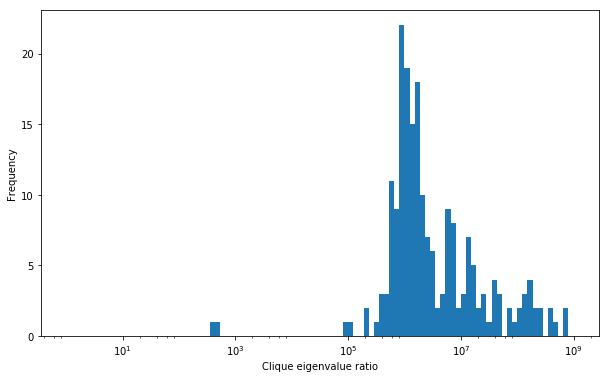

In [6]:
%pylab inline
from pylab import plot,xlabel,ylabel,arange,linspace,hist,xscale,rcParams
rcParams['figure.figsize'] = (10, 6)

if len(sol['eigratio']) == 1:
    print("Eigenvalue ratio: %.2e" % (sol['eigratio'][0]))
else:
    import numpy as np
    hist(sol['eigratio'],bins=[10.**a for a in linspace(0,9,100)])
    xscale('log')
    xlabel('Clique eigenvalue ratio')
    ylabel('Frequency')
    print("Cliques with eigenvalue ratio less than 1e5: %i of %i"\
          % (len([1 for evr in sol['eigratio'] if evr < 1e5]),len(sol['eigratio'])))

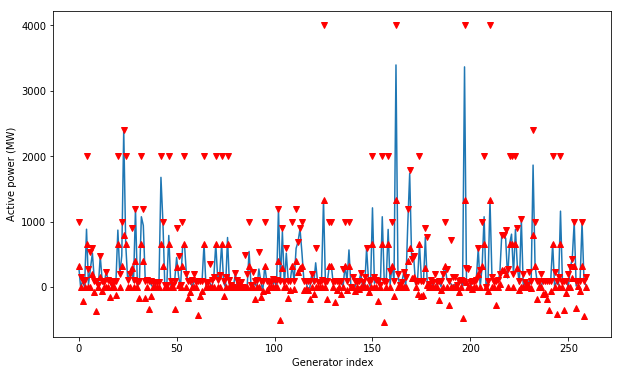

In [7]:
plot(sol['Sg'].real())
plot([gen['Pmin']*prob.baseMVA for gen in prob.generators],'r^')
plot([gen['Pmax']*prob.baseMVA for gen in prob.generators],'rv')
xlabel('Generator index')
ylabel('Active power (MW)')

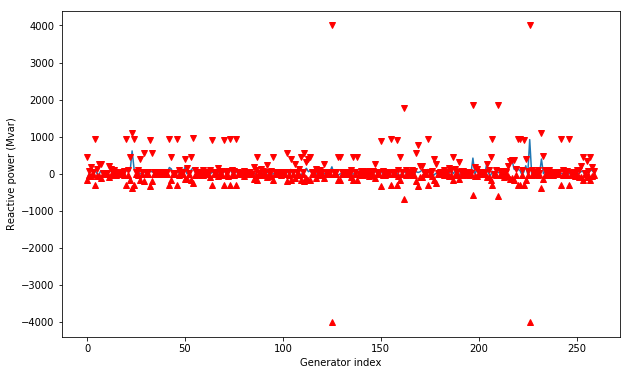

In [8]:
plot(sol['Sg'].imag())
plot([gen['Qmin']*prob.baseMVA for gen in prob.generators],'r^')
plot([gen['Qmax']*prob.baseMVA for gen in prob.generators],'rv')
xlabel('Generator index')
ylabel('Reactive power (Mvar)');

## Voltage magnitude constraints

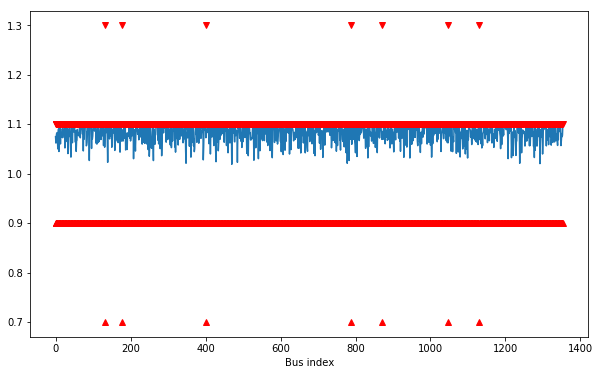

In [9]:
plot(sol['Vm'])
plot([b['minVm'] for b in prob.busses],'r^')
plot([b['maxVm'] for b in prob.busses],'rv')
xlabel('Bus index');

## Flow constraints

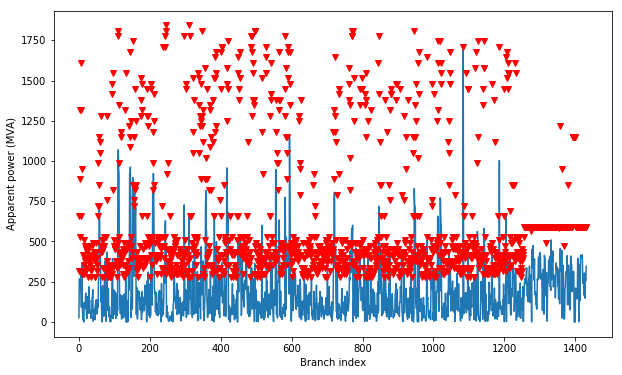

In [10]:
if prob.branches_with_flow_constraints():
    pyplot.plot(abs(sol['St']))
    pyplot.plot([br['rateA'] for _,br in prob.branches_with_flow_constraints()],'rv')
    pyplot.xlabel('Branch index')
    pyplot.ylabel('Apparent power (MVA)')
else:
    print("No flow constraints.")